In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import os
from hashlib import sha256
from itertools import count, product
from typing import Tuple, List

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import tensorflow as tf
import json
import time

import gymnasium as gym

In [2]:
protos_per_dim = 10
action_ls = [0,1]

In [3]:
#initialize
w = np.zeros((protos_per_dim**3, len(action_ls)))
print(w.shape)

(1000, 2)


In [21]:
cart_pos_min_max = (-4.8000002, 4.8000002)
pole_pos_min_max = (-4.1887903, 4.1887903)
pole_vel_min_max = (-3.4028235, 3.4028235) #-3.4028235e+38, 3.4028235e+38

# proto_points = get_proto_points()
sn_plot_points = 100
print(pole_vel_min_max)

(-3.4028235, 3.4028235)


In [22]:
print(*cart_pos_min_max, protos_per_dim + 2)

-4.8000002 4.8000002 12


In [23]:
#Returns the proto points for the RBF. These are the centers of the Gaussian basis functions
proto_cart_pos = np.linspace(*cart_pos_min_max, protos_per_dim + 2)[1:-1]
proto_pole_pos = np.linspace(*pole_pos_min_max, protos_per_dim + 2)[1:-1]
proto_pole_vel = np.linspace(*pole_vel_min_max, protos_per_dim + 2)[1:-1]

# print(np.linspace(*pole_vel_min_max, protos_per_dim + 2))
print(proto_cart_pos.shape)
print(proto_pole_pos.shape)
print(proto_pole_vel.shape)

proto_points = np.array(list(product(proto_cart_pos, proto_pole_pos, proto_pole_vel)))
print(proto_points.shape)
print(proto_points)

(10,)
(10,)
(10,)
(1000, 3)
[[-3.92727289 -3.42719206 -2.78412832]
 [-3.92727289 -3.42719206 -2.16543314]
 [-3.92727289 -3.42719206 -1.54673795]
 ...
 [ 3.92727289  3.42719206  1.54673795]
 [ 3.92727289  3.42719206  2.16543314]
 [ 3.92727289  3.42719206  2.78412832]]


In [24]:
epsilon = 0
q = (0.1, 0.1, 1)

In [25]:
distance_scaler = 0.005

In [26]:
def rbf_vec(cart_pos: float, pole_pos: float, pole_vel: float) -> np.ndarray:
        """Returns the normalized RBF vector for the given state."""
        s = np.array([cart_pos, pole_pos, pole_vel])
        cart_pos_scale = cart_pos_min_max[1] - cart_pos_min_max[0]
        pole_pos_scale = pole_pos_min_max[1] - pole_pos_min_max[0]
        pole_vel_scale = pole_vel_min_max[1] - pole_vel_min_max[0]
        dist_components = (s - proto_points) / (
            np.array([cart_pos_scale, pole_pos_scale, pole_vel_scale]) * distance_scaler
        )
        radial_basis = np.exp(-(dist_components**2).sum(1))
        return radial_basis / radial_basis.sum()

In [27]:
def q(cart_pos: float, pole_pos: float, pole_vel: float, a: int) -> float:
        """Returns the linearly-estimated Q-value for a given state and action."""
        return w[:, a].dot(rbf_vec(cart_pos, pole_pos, pole_vel))

In [28]:
def select_action(cart_pos: float, pole_pos: float, pole_vel):
    """Selects an action using epsilon-greedy."""
    if np.random.uniform() < epsilon:
        return np.random.choice(action_ls)
    else:
        return max(action_ls, key=lambda a: q(cart_pos, pole_pos, pole_vel, a))

In [29]:
def map_discrete_state(cs):
    cs[0] = int(cs[0] * 10)
    cs[1] = int(cs[1] * 10)
    cs[2] = int(cs[2] * 10)
    cs[3] = int(cs[3] * 10)
    
    ds = tuple(cs)
    return ds

In [88]:
def reward_function(ds, culmulative_reward, dt, targetAngle, prev_agent_pos, terminated, top_botom_penalty):

    angle_fixrate = np.deg2rad(1.0)

    if ds[0] < targetAngle:
        targetAngle += angle_fixrate * dt
    else:
        targetAngle -= angle_fixrate * dt

    error_cart_pos = abs(ds[0])

    error_pole_pos = abs(ds[2])

    cart_pos = ds[0]
    pole_pos = ds[2]*100
    pole_vel = ds[3]*1.5

    agent_pos = -(cart_pos**2 + pole_pos**2 + pole_vel**2)  

    if error_pole_pos < (90 * 2 * np.pi / 360):
        top_botom_penalty = 10000
    else:
        top_botom_penalty = -10000

    delta_agent_pos = agent_pos - prev_agent_pos

    # time_reward = (culmulative_reward)/500
    # print("time_reward", time_reward)

    if terminated:
        termination_penalty = -100000000000
    else:
        termination_penalty = 0

    reward = delta_agent_pos  #error_pole_pos  + error_cart_pos/10 

    return reward, error_cart_pos, error_pole_pos, agent_pos, top_botom_penalty

In [14]:
environment_name = 'CartPole-v1'
# env = gym.make(environment_name, render_mode="human")
env = gym.make(environment_name)

In [15]:
# hyperparameters
learning_rate = 0.2 #0.01
n_episodes = 100
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.95

# agent = CartPoleAgent(
#     learning_rate=learning_rate,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
# )

In [16]:
obs, info = env.reset()

In [23]:
w = np.ones((4, 2))

In [24]:
w[:,0]

array([1., 1., 1., 1.])

In [18]:
print(obs)

[0.02915875 0.03435668 0.00479647 0.04937898]


In [25]:
w[:,0].dot(obs)

0.11769087240099907

In [97]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

dis_play_list =[]

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    score = 0
    discrete_state = (0, 0, 0, 0)
    discrete_reward = 0
    new_discrete_state = [0, 0, 0, 0]
    iteration = 0
    
    prev_agent_pos = 0

    top_botom_penalty = 0

    prev_time = 0

    targetAngle = 0

    # Choose a from s using policy derived from Q
    # action = agent.get_action(discrete_state)
    action = select_action(obs[0], obs[2], obs[3])

    # play one episode
    while not done:
        env.render()
        # action = agent.get_action(discrete_state) #obs
        next_obs, reward, terminated, truncated, info = env.step(action)
        # print(reward)
        # if terminated:
        #     reward = - 10

        done = terminated or truncated

        score += reward

        reward, error_cart_pos, error_pole_pos, prev_agent_pos, top_botom_penalty = reward_function(next_obs, score, 0, targetAngle, prev_agent_pos, terminated, top_botom_penalty)

        if done:
            w[:, action] += (
                learning_rate * (reward - q(obs[0], obs[2], obs[3], action)) * rbf_vec(obs[0], obs[2], obs[3])
            )
        else:
            next_action = select_action(next_obs[0], next_obs[2], next_obs[3])
            w[:, action] += (
                learning_rate * (reward + discount * q(next_obs[0], next_obs[2], next_obs[3], next_action) - q(obs[0], obs[2], obs[3], action)) * rbf_vec(obs[0], obs[2], obs[3])
            )

            obs = next_obs
            action = next_action

        

    dis_play_list.append(score)

    epsilon = max(final_epsilon, epsilon - epsilon_decay)

  0%|          | 0/100 [00:00<?, ?it/s]d:\anacoda3\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


In [ ]:
env.close()

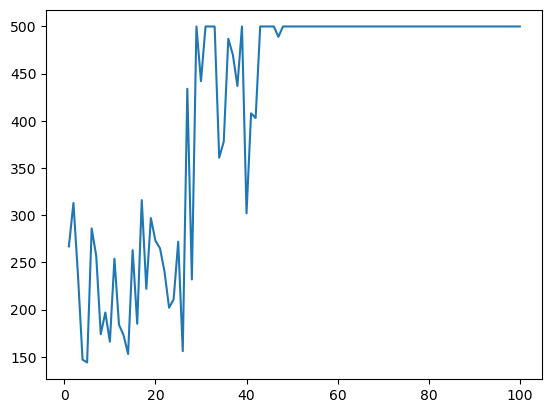

In [92]:
display_np = np.array(dis_play_list)

t = np.linspace(1, len(display_np), len(display_np))

plt.plot(t, display_np)
plt.show() 